In [1]:
# -*- coding: utf-8 -*-
"""
Created on Wed Sep 25 16:16:15 2019

@author: Błażej Ćwikliński

@description: The project is conducted for learning purposes. I will try to apply
                some Machine Learning techniques on insurance.csv dataset, having 
                tools provided by SciKit-Learn.

@objective: Creating a model capable of predicting amount of charged money.

@sources: "Hands-on Machine Learning with SciKit-Learn & Tensorflow" by Aurélien Géron (O'Reilly)
          https://www.youtube.com/user/sentdex -> sentdex channel on Youtube
          https://scikit-learn.org/stable/index.html -> SciKit-Learn documentation
          https://www.kaggle.com/mirichoi0218/insurance -> dataset available here
"""

import numpy as np
import pandas as pd



# DATA PREPARATION #

path ='datasets\insurance.csv' # manually downloaded dataset from Kaggle
insure = pd.read_csv(path)

insure.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


In [2]:
insure.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
age         1338 non-null int64
sex         1338 non-null object
bmi         1338 non-null float64
children    1338 non-null int64
smoker      1338 non-null object
region      1338 non-null object
charges     1338 non-null float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.2+ KB


In [3]:
# Well, we do not have any missing values, which is always a great thing
# Let's just take a look into some statistics about numerical attributes

insure.describe()

,age,bmi,children,charges
count,1338.000000,1338.000000,1338.000000,1338.000000
mean,39.207025,30.663397,1.094918,13270.422265
std,14.049960,6.098187,1.205493,12110.011237
min,18.000000,15.960000,0.000000,1121.873900
25%,27.000000,26.296250,0.000000,4740.287150
50%,39.000000,30.400000,1.000000,9382.033000
75%,51.000000,34.693750,2.000000,16639.912515
max,64.000000,53.130000,5.000000,63770.428010


In [4]:
# Let's see what's hidden under the 'object' label

insure['sex'].value_counts()

male      676
female    662
Name: sex, dtype: int64

In [5]:
insure['smoker'].value_counts()

no     1064
yes     274
Name: smoker, dtype: int64

In [6]:
insure['region'].value_counts()

southeast    364
northwest    325
southwest    325
northeast    324
Name: region, dtype: int64

In [7]:
# We should think about encoding the categorical values from our dataset:

from sklearn.preprocessing import LabelEncoder
encoder =  LabelEncoder()

insure_sex =  insure["sex"]
insure_smoker =  insure["smoker"]
insure_region =  insure["region"]

insure_sex_encoded = encoder.fit_transform(insure_sex)
insure_smoker_encoded = encoder.fit_transform(insure_smoker)
insure_region_encoded = encoder.fit_transform(insure_region)

In [8]:
insure_sex_encoded

array([0, 1, 1, ..., 0, 0, 0])

In [9]:
insure_smoker_encoded

array([1, 0, 0, ..., 0, 0, 1])

In [10]:
insure_region_encoded

array([3, 2, 2, ..., 2, 3, 1])

In [11]:
#  Great - now let's attach it back again (encoded)

insure_dropped = insure.drop(['sex', 'smoker', 'region'], axis = 1) 

insure_dropped['sex_en'] = insure_sex_encoded.copy()
insure_dropped['smoker_en'] = insure_smoker_encoded.copy()
insure_dropped['region_en'] = insure_region_encoded.copy()
insure_dropped.head()

,age,bmi,children,charges,sex_en,smoker_en,region_en
0,19,27.900,0,16884.92400,0,1,3
1,18,33.770,1,1725.55230,1,0,2
2,28,33.000,3,4449.46200,1,0,2
3,33,22.705,0,21984.47061,1,0,1
4,32,28.880,0,3866.85520,1,0,1


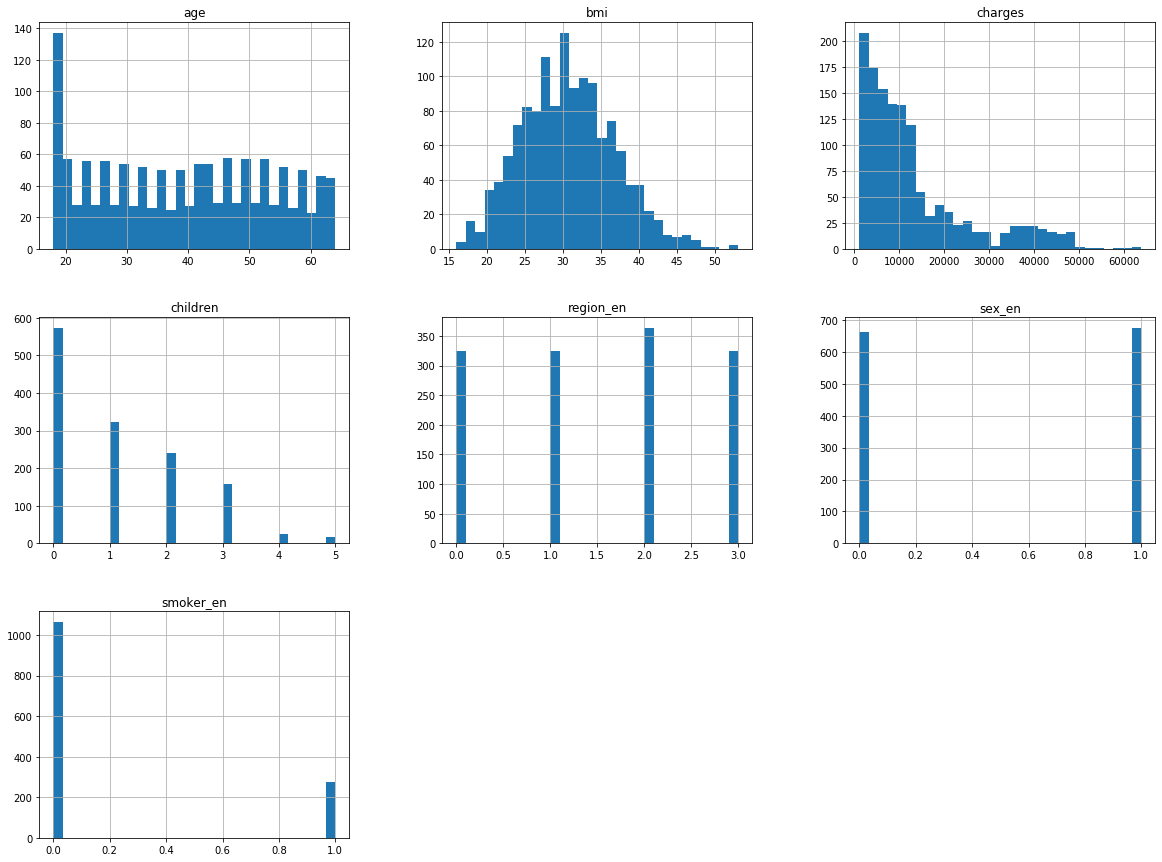

In [12]:
# Let's keep on exploring: now by plotting some values.


import matplotlib.pyplot as plt
%matplotlib inline 
insure_dropped.hist(figsize = (20, 15), bins = 30)
plt.show()  

In [13]:
# Now, we will meassure correlation between the 'charges' and other features

matr = insure_dropped.corr()
abs(matr['charges']).sort_values(ascending = False)

charges      1.000000
smoker_en    0.787251
age          0.299008
bmi          0.198341
children     0.067998
sex_en       0.057292
region_en    0.006208
Name: charges, dtype: float64

In [14]:
# Let's see if we can manage to add some reasonable attributes:

insure_dropped['bmi_over_age'] = insure['bmi'] / insure['age']

matr = insure_dropped.corr()
abs(matr['charges']).sort_values(ascending = False)

charges         1.000000
smoker_en       0.787251
age             0.299008
bmi             0.198341
bmi_over_age    0.159730
children        0.067998
sex_en          0.057292
region_en       0.006208
Name: charges, dtype: float64

In [15]:
# It ain't much, but we other combinations were simply useless

# Now I'm gonna drop 'region_en' column, cause the correlation is super weak
# and I don't want my algorithms to get crack because of it

insure = insure_dropped.drop(['region_en'], axis = 1)
insure.head()

,age,bmi,children,charges,sex_en,smoker_en,bmi_over_age
0,19,27.900,0,16884.92400,0,1,1.468421
1,18,33.770,1,1725.55230,1,0,1.876111
2,28,33.000,3,4449.46200,1,0,1.178571
3,33,22.705,0,21984.47061,1,0,0.688030
4,32,28.880,0,3866.85520,1,0,0.902500


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000021F21A53C88>,
      dtype=object)

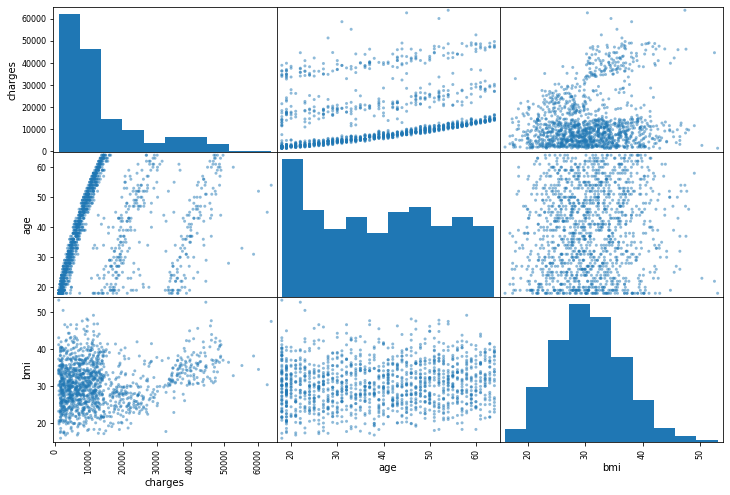

In [16]:
# Now, let's see how those correlations look like:

from pandas.plotting import scatter_matrix

attributes = ["charges", "age", "bmi"]

scatter_matrix(insure[attributes], figsize = (12, 8))

In [17]:
# Alright, everything seems to be fine - we can now split the data into two sets:


from sklearn.model_selection import train_test_split
train_set, test_set = train_test_split(insure, test_size = 0.2, random_state = 42)

In [18]:
# Just to make sure:
# that's what part of the whole frame is the test set:

test_prc = len(test_set) / (len(test_set) + len(train_set))
print(test_prc)

0.20029895366218237


In [19]:
# Since we splitted our data into two separated test, we can jump into 
# more interesting stuff


# To make sure we won't use the test set till the very end let's substiture the
# insure DataFrame with train_set

# test
test = test_set.drop(['charges'], axis = 1)
test_labels = test_set['charges'].copy()

# training
insure = train_set.drop(['charges'], axis = 1)
insure_labels = train_set['charges'].copy()

In [20]:
# Since we can't ensure correlation between objects and target value
# let's drop old values (object) and ubstitute them with our encoded ones

insure.head()

,age,bmi,children,sex_en,smoker_en,bmi_over_age
560,46,19.95,2,0,0,0.433696
1285,47,24.32,0,0,0,0.517447
1142,52,24.86,0,0,0,0.478077
969,39,34.32,5,0,0,0.880000
486,54,21.47,3,0,0,0.397593


In [21]:
insure.shape

(1070, 6)

In [22]:
test.shape

(268, 6)

In [23]:
# Finally we got to apply some ML algorithms:

# @LINEAR
# @LINEAR_LASSO
# @LINEAR_LASSO_LARS
# @DECISION_TREE
# @SUPPORT_VECTOR
# @RANDOM_FOREST
# @GRADIENT_BOOSTING

# Now, I'll be trying to find best 2 models

In [24]:
# We will also cross-validate all the methods
from sklearn.model_selection import cross_val_score

In [25]:
# Let's start with 3 similar linear regression models:
from sklearn import linear_model

# @LINEAR
lin = linear_model.LinearRegression()
lin.fit(insure, insure_labels)
print("Accuracy: %.2f" % lin.score(test, test_labels))

lin_score = cross_val_score(lin, insure, insure_labels, cv = 10)
print("CV accuracy: %.2f (+/- %.2f)" % (lin_score.mean(), lin_score.std() * 2))

Accuracy: 0.78
CV accuracy: 0.73 (+/- 0.14)


In [26]:
# @LINEAR_LASSO
lasso = linear_model.Lasso(alpha = 0.1)
lasso.fit(insure, insure_labels)
print("Accuracy: %.2f" % lasso.score(test, test_labels))

lasso_score = cross_val_score(lasso, insure, insure_labels, cv = 10)
print("CV accuracy: %.2f (+/- %.2f)" % (lasso_score.mean(), lasso_score.std() * 2))

Accuracy: 0.78
CV accuracy: 0.73 (+/- 0.14)


In [27]:
# @LINEAR_LASSO_LARS
lasso_lars = linear_model.LassoLars(alpha = 0.1)
lasso_lars.fit(insure, insure_labels)
print("Accuracy: %.2f" % lasso_lars.score(test, test_labels))

lasso_lars_score = cross_val_score(lasso_lars, insure, insure_labels, cv = 10)
print("CV accuracy: %.2f (+/- %.2f)" % (lasso_lars_score.mean(), lasso_lars_score.std() * 2))

Accuracy: 0.78
CV accuracy: 0.73 (+/- 0.14)


In [28]:
# Let's try how good ol' trees perform as well:
from sklearn.tree import DecisionTreeRegressor

# @DECISION_TREE
tree = DecisionTreeRegressor()
tree.fit(insure, insure_labels)
print("Accuracy: %.2f" % tree.score(test, test_labels))

tree_score = cross_val_score(tree, insure, insure_labels, cv = 10)
print("CV accuracy: %.2f (+/- %.2f)" % (tree_score.mean(), tree_score.std() * 2))

Accuracy: 0.77
CV accuracy: 0.69 (+/- 0.13)


In [29]:
# And so Support Vector Machines:
from sklearn.svm import SVR

# @SUPPORT_VECTOR
sv_reg = SVR(kernel = 'linear', C = 2000, gamma = 'auto')
sv_reg.fit(insure, insure_labels)
print("Accuracy: %.2f" % sv_reg.score(test, test_labels))

sv_reg_score = cross_val_score(sv_reg, insure, insure_labels, cv = 10)
print("CV accuracy: %.2f (+/- %.2f)" % (sv_reg_score.mean(), sv_reg_score.std() * 2))

Accuracy: 0.75
CV accuracy: 0.67 (+/- 0.23)


In [30]:
# Finally some ensembled ones as well:
from sklearn.ensemble import RandomForestRegressor

# @RANDOM_FOREST
forest = RandomForestRegressor(n_estimators = 100)
forest.fit(insure, insure_labels)
print("Accuracy: %.2f" % forest.score(test, test_labels))

forest_score = cross_val_score(forest, insure, insure_labels, cv = 10)
print("CV accuracy: %.2f (+/- %.2f)" % (forest_score.mean(), forest_score.std() * 2))

Accuracy: 0.86
CV accuracy: 0.81 (+/- 0.09)


In [31]:
# And the one with the coolest name for the last: 
from sklearn.ensemble import GradientBoostingRegressor

# @GRADIENT_BOOSTING
gb = GradientBoostingRegressor()
gb.fit(insure, insure_labels)
print("Accuracy: %.2f" % gb.score(test, test_labels))

gb_score = cross_val_score(gb, insure, insure_labels, cv = 10)
print("CV accuracy: %.2f (+/- %.2f)" % (gb_score.mean(), gb_score.std() * 2))

Accuracy: 0.88
CV accuracy: 0.84 (+/- 0.09)


In [32]:
# All the Linear Regression models performed exactly the same
# Decision Trees were a bit behind them
# SVM-s did almost as good as Linear Models (but the errors here were greater)
# yet, finally
# Gradient Boosting and Random Forest gave some pretty good predictions

In [33]:
# We will now stick to Gradient Boosting & Random Forest
# Let's choose the grid:

from sklearn.model_selection import GridSearchCV
from scipy.stats import randint

In [39]:
# Random Forest
rf_param = {'max_depth': [5, 6, 7, None],
            'max_features': [2, 3, 4, 5, 6],
            'min_samples_split': [2, 3, 4],
            'bootstrap': [True, False]}
              
rf_grid = GridSearchCV(forest, rf_param, cv = 10, scoring = 'neg_mean_squared_error')
rf_grid.fit(insure, insure_labels)

GridSearchCV(cv=10, error_score='raise-deprecating',
             estimator=RandomForestRegressor(bootstrap=True, criterion='mse',
                                             max_depth=None,
                                             max_features='auto',
                                             max_leaf_nodes=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             n_estimators=100, n_jobs=None,
                                             oob_score=False, random_state=None,
                                             verbose=0, warm_start=False),
             iid='warn', n_jobs=None,
             param_grid={'bootstrap': [True, False],
     

In [40]:
rf_grid.best_params_

{'bootstrap': True, 'max_depth': 5, 'max_features': 4, 'min_samples_split': 2}

In [41]:
rf_grid.best_estimator_

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=5,
                      max_features=4, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=100,
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=0, warm_start=False)

In [42]:
rf_final = rf_grid.best_estimator_
rf_final.score(test, test_labels)

0.8779213202921221

In [43]:
# That's probably as far as we can get with Random Forest, but 87,65% is not too bad

In [44]:
# Moving on - let's try to find those grids for Gradient Boosting now:

# Gradient Boosting
gb_param = {'learning_rate': np.linspace(0.1, 0.3, 12),
            'max_depth': [3, 5, 6],
            'max_features': ['sqrt', 'log2'],
            'min_samples_leaf': [2, 3, 4, 5, 6],
            'min_samples_split': [3, 4, 5],
            'n_estimators': [50],
            'criterion': ['friedman_mse', 'mae']}
                

gb_grid = GridSearchCV(gb, gb_param, cv = 10, n_jobs = -1)
gb_grid.fit(insure, insure_labels)

GridSearchCV(cv=10, error_score='raise-deprecating',
             estimator=GradientBoostingRegressor(alpha=0.9,
                                                 criterion='friedman_mse',
                                                 init=None, learning_rate=0.1,
                                                 loss='ls', max_depth=3,
                                                 max_features=None,
                                                 max_leaf_nodes=None,
                                                 min_impurity_decrease=0.0,
                                                 min_impurity_split=None,
                                                 min_samples_leaf=1,
                                                 min_samples_split=2,
                                                 min_weight_fraction_leaf=0.0,
                                                 n_estimators=100,
                                                 n_ite...
                         'lea

In [45]:
gb_grid.best_params_

{'criterion': 'friedman_mse',
 'learning_rate': 0.13636363636363635,
 'max_depth': 3,
 'max_features': 'sqrt',
 'min_samples_leaf': 6,
 'min_samples_split': 3,
 'n_estimators': 50}

In [46]:
gb_grid.best_estimator_

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
                          learning_rate=0.13636363636363635, loss='ls',
                          max_depth=3, max_features='sqrt', max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=6, min_samples_split=3,
                          min_weight_fraction_leaf=0.0, n_estimators=50,
                          n_iter_no_change=None, presort='auto',
                          random_state=None, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

In [48]:
gb_final = gb_grid.best_estimator_
gb_final.score(test, test_labels)

0.8779545373628443

In [51]:
# So the Gradient Boosting model was able to predict the outcome with 87.80% accuracy
# and that is almost precisely the same output as Fandom Forest.


# The last thing to be done is calculating RMSE for both methods:
from sklearn.metrics import mean_squared_error

# Random Forest
rf_predictions = rf_final.predict(test)

rf_mse = mean_squared_error(test_labels, rf_predictions)
rf_rmse = np.sqrt(rf_mse)
rf_rmse

4353.453820455496

In [52]:
# Gradient Boosting
gb_predictions = gb_final.predict(test)

gb_mse = mean_squared_error(test_labels, gb_predictions)
gb_rmse = np.sqrt(gb_mse)
gb_rmse

4352.861502361986

In [ ]:
# CONCLUSION

# Best accuracy was obtained by using ensembled learning methods.
# Both our methods gave us approximately 88% of accuracy, with RMSE 
# equal about 4353.
# The differences may have been caused by not perfectly optimised 
# grid, Gradient Boosting was a slightly ahead in all of our observations.
# Performance of both models is acceptable.